In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import linregress
import os

files = glob.glob('modis_*_China.csv')
print(files)
all_data = []
for file in files:
    try:
        year = int(file.split('_')[1]) 
        df = pd.read_csv(file)
        df['year'] = year
        all_data.append(df)
        print(f"{file}: {len(df)} records")
    except Exception as e:
        print(f"Read failed: {file}, reason: {e}")
data = pd.concat(all_data, ignore_index=True)
print(f"{len(files)} ，{len(data)} 。")

print("Data column names:", data.columns.tolist())
print(data.head())

['modis_2013_China.csv', 'modis_2018_China.csv', 'modis_2015_China.csv', 'modis_2012_China.csv', 'modis_2019_China.csv', 'modis_2014_China.csv', 'modis_2011_China.csv', 'modis_2017_China.csv', 'modis_2010_China.csv', 'modis_2016_China.csv']
modis_2013_China.csv: 118010 records
modis_2018_China.csv: 78673 records
modis_2015_China.csv: 122990 records
modis_2012_China.csv: 95653 records
modis_2019_China.csv: 88539 records
modis_2014_China.csv: 150807 records
modis_2011_China.csv: 103345 records
modis_2017_China.csv: 114317 records
modis_2010_China.csv: 103118 records
modis_2016_China.csv: 97667 records
10 ，1073119 。
数据列名： ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'year']
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   39.1092   106.6029       312.3   1.5    1.2  2013-01-01       329   
1   39.1160   106.5980       304.6   1.5    1

In [89]:
# verify
print(data['year'].value_counts().sort_index())

year
2010    103118
2011    103345
2012     95653
2013    118010
2014    150807
2015    122990
2016     97667
2017    114317
2018     78673
2019     88539
Name: count, dtype: int64


In [49]:
# Step 2:Data cleaning

data = data.drop_duplicates()
print(f"After deduplication: {len(data):,}")

#(0 = Vegetation fire, 1 = Volcano, 2 = Other static terrestrial sources, 3 = Offshore)
if 'type' in data.columns:
    original = len(data)
    data = data[data['type'] == 0] 
    print(f"After filtering type==0: {len(data):,} ({original - len(data):,} removed)")
else:
    print("Warning: 'type' column missing — may include non-fire pixels")

if 'acq_date' not in data.columns:
    raise KeyError("Column 'acq_date' not found. Required for temporal analysis.")
    
data['acq_date'] = pd.to_datetime(data['acq_date'], errors='coerce')#Convert illegal dates to NaT
data = data.dropna(subset=['acq_date'])#Delete invalid dates
data['date'] = data['acq_date'].dt.date  # Gather the sun together

#Filter the boundary frame of Heilongjiang Province (from 121°11′E in the west to 135°05′E in the east, from 43°26′N in the south to 53°33′N in the north).
HLJ_BOUNDS = {
    'lon_min': 121.1,
    'lon_max': 135.0,
    'lat_min': 43.3,
    'lat_max': 53.3
}

mask = (
    (data['longitude'] >= HLJ_BOUNDS['lon_min']) &
    (data['longitude'] <= HLJ_BOUNDS['lon_max']) &
    (data['latitude'] >= HLJ_BOUNDS['lat_min']) &
    (data['latitude'] <= HLJ_BOUNDS['lat_max']) &
    (data['year'] >= 2010) & (data['year'] <= 2019)
)

data_hlj = data[mask].copy()
print(f"Within Heilongjiang (2010–2019): {len(data_hlj):,}")

# Deduplication is performed daily and using a grid of approximately 1 kilometer (to avoid duplicate recordings by Terra and Aqua).
data_hlj['lat1km'] = np.round(data_hlj['latitude'], 2)
data_hlj['lon1km'] = np.round(data_hlj['longitude'], 2)
subset_cols = ['date', 'lat1km', 'lon1km']
if 'satellite' in data_hlj.columns:
    subset_cols.append('satellite')

data_clean = data_hlj.drop_duplicates(subset=subset_cols)
print(f"After daily-spatial deduplication: {len(data_clean):,}")

After deduplication: 1,073,119
After filtering type==0: 991,374 (81,745 removed)
Within Heilongjiang (2010–2019): 288,216
After daily-spatial deduplication: 282,587


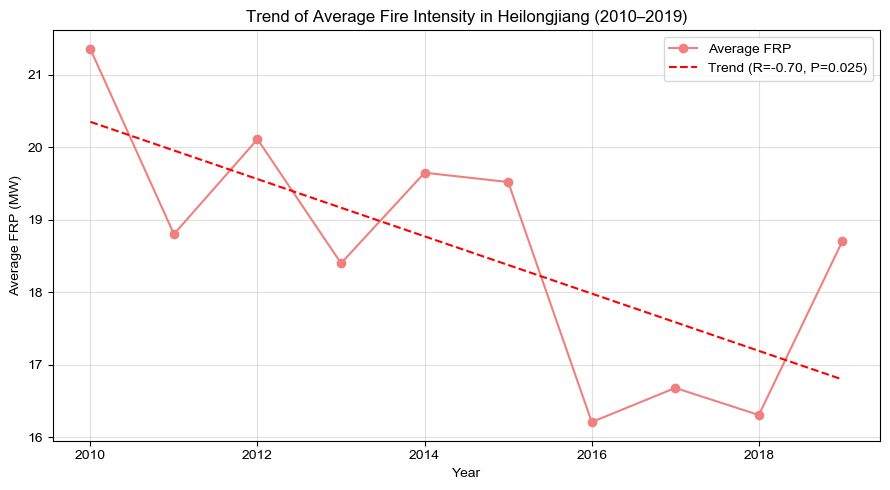

Regression analysis results：
Slope: -0.3948 MW/Year
R: -0.696
P-value: 0.025
Conclusion: Between 2010 and 2019, the average fire intensity showed a Significant decrease


In [87]:
annual_avg_frp = data.groupby('year')['frp'].mean()

slope, intercept, r_value, p_value, std_err = linregress(annual_avg_frp.index, annual_avg_frp.values)

plt.figure(figsize=(9, 5))
plt.plot(annual_avg_frp.index, annual_avg_frp.values,  marker='o',color='lightcoral', label='Average FRP')
plt.plot(annual_avg_frp.index, intercept + slope * annual_avg_frp.index, '--r', label=f'Trend (R={r_value:.2f}, P={p_value:.3f})')

plt.xlabel('Year')
plt.ylabel('Average FRP (MW)')
plt.title('Trend of Average Fire Intensity in Heilongjiang (2010–2019)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Regression analysis results：")
print(f"Slope: {slope:.4f} MW/Year")
print(f"R: {r_value:.3f}")
print(f"P-value: {p_value:.3f}")
if p_value < 0.05:
    if slope > 0:
        trend = "Significant increase"
    else:
        trend = "Significant decrease"
else:
    trend = "No Significant change"
print(f"Conclusion: Between 2010 and 2019, the average fire intensity showed a {trend}")

In [13]:
# Step 3: 
annual = data_clean.groupby('year').size().reset_index(name='fire_count')
# Fill in missing years (e.g., years without fire points) and set them to 0 to avoid regression errors.
full_years = pd.DataFrame({'year': range(2010, 2020)})
annual = full_years.merge(annual, on='year', how='left').fillna(0).astype({'fire_count': int})
x = annual['year']
y = annual['fire_count']
# Using linear regression to determine trends
slope, intercept, r_value, p_value, _ = linregress(x, y)
trend_line = slope * x + intercept
print(f"  Slope: {slope:.1f}")
print(f"  R²: {r_value**2:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Conclusion: {'Significant decrease' if slope < 0 and p_value < 0.05 else 'No significant trend'}")

  Slope: 1165.2
  R²: 0.069
  p-value: 0.4636
  Conclusion: No significant trend


Best candidate for turning point: 2018
Before 2018: avg 30540
After 2018: avg 19132
Change: -37.4%


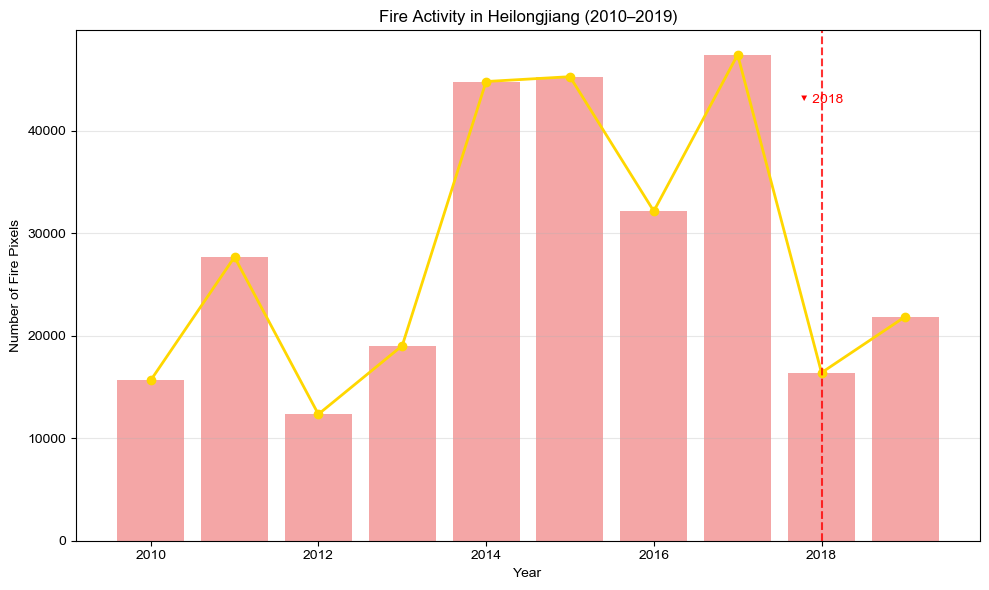

In [86]:
# Step 4 (Final): Smart Turning Point Detection
# Using "Before vs After" mean comparison
years = annual['year'].values
counts = annual['fire_count'].values
candidates = []
for year in range(2010, 2019):  # Test from 2010 to 2019
    before = counts[years < year]
    after = counts[years >= year]
   
    if len(before) < 3 or len(after) < 2:
        continue        
    change = np.mean(after) - np.mean(before)
    relative_change = change / np.mean(before) 
    
# Significant decrease: decrease > 30%, and after the mean < before.
    if np.mean(after) < np.mean(before) and relative_change < -0.3:
        candidates.append({
            'break_year': year,
            'before_mean': np.mean(before),
            'after_mean': np.mean(after),
            'change': relative_change * 100
        })
candidates = sorted(candidates, key=lambda x: x['change'])

if candidates:
    best = candidates[0]
    print(f"Best candidate for turning point: {best['break_year']}")
    print(f"Before {best['break_year']}: avg {best['before_mean']:.0f}")
    print(f"After {best['break_year']}: avg {best['after_mean']:.0f}")
    print(f"Change: {best['change']:.1f}%")
else:
    print("No clear turning point detected")
plt.figure(figsize=(10, 6))
plt.bar(annual['year'], annual['fire_count'], color='lightcoral', alpha=0.7)
plt.plot(annual['year'], annual['fire_count'], 'o-', color='gold', linewidth=2)

# If there is an inflection point, draw a line.
if candidates:
    cp = candidates[0]['break_year']
    plt.axvline(cp, color='red', linestyle='--', alpha=0.8)
    plt.text(cp, max(annual['fire_count'])*0.9, f'▼ {cp}', color='red', ha='center')

plt.title('Fire Activity in Heilongjiang (2010–2019)')
plt.xlabel('Year')
plt.ylabel('Number of Fire Pixels')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [85]:
def get_season(month):
    """
    Determine the season based on the month (Main straw burning season）
    Spring: March, April, and May
    Autumn: September, October, November
    """
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'other'
def create_and_save_trend_map(data_clean):
    print("Create a map...")
    print("Data on peak straw burning periods in spring and autumn")
    if 'acq_date' in data_clean.columns:
        data_clean['acq_date'] = pd.to_datetime(data_clean['acq_date'])
        data_clean['month'] = data_clean['acq_date'].dt.month
    elif 'date' in data_clean.columns:
        data_clean['date'] = pd.to_datetime(data_clean['date'])
        data_clean['month'] = data_clean['date'].dt.month
    data_clean['season'] = data_clean['month'].apply(get_season)
    seasonal_data = data_clean[data_clean['season'].isin(['spring', 'autumn'])]
    
    print(f"Original data points: {len(data_clean)}")
    print(f"Spring and Autumn Data Points: {len(seasonal_data)}")
    print(f"Seasonal distribution:\n{seasonal_data['season'].value_counts()}")
    seasonal_data['grid_lat'] = np.round(seasonal_data['latitude'], 1)
    seasonal_data['grid_lon'] = np.round(seasonal_data['longitude'], 1)
    seasonal_data['grid_id'] = seasonal_data['grid_lat'].astype(str) + '_' + seasonal_data['grid_lon'].astype(str)
    print("Computing grid-level interannual trends...")
    grid_year = seasonal_data.groupby(['grid_id', 'year']).size().unstack(fill_value=0)
    
    trend_results = []
    for grid, row in grid_year.iterrows():
        years = row.index.values
        counts = row.values
        
        if len(counts) > 5 and sum(counts) > 10:
            
            change_rate = (counts[-1] - counts[0]) / counts[0] if counts[0] > 0 else 0
            avg_fires = np.mean(counts)
            
            trend_results.append({
                'grid_id': grid,
                'center_lat': float(grid.split('_')[0]),
                'center_lon': float(grid.split('_')[1]),
                'change_rate': change_rate,
                'avg_fires': avg_fires,
                'total_fires': sum(counts)
            })
    
    if not trend_results:
        print("No trend data was generated")
        return
        
    df_trend = pd.DataFrame(trend_results)
    df_trend['trend_category'] = np.select([
        df_trend['change_rate'] < -0.3,
        df_trend['change_rate'] > 0.3
    ], [
        'Decrease',
        'Increase'
    ], default='Stable')
    plt.figure(figsize=(12, 10))
    colors = {
        'Decrease': '#8FDEE3',   
        'Stable': '#FDD786',   
        'Increase': '#F78779'    
    }
    for category in df_trend['trend_category'].unique():
        subset = df_trend[df_trend['trend_category'] == category]
        plt.scatter(subset['center_lon'], subset['center_lat'],
                   c=colors[category], label=category,
                   alpha=0.8, s=40, edgecolors='white', linewidth=0.5)
    cities = {
        'Da Xing An Ling': (124.12, 50.42),
        'Hei He': (127.50, 50.25), 
        'Qi Qi Ha Er': (123.92, 47.35),
        'Da Qing': (125.03, 46.58),
        'Sui Hua': (126.98, 46.63),
        'Ha Er Bin': (126.63, 45.76),
        'Mu Dan Jiang': (129.60, 44.58)
    }
    
    for city, (lon, lat) in cities.items():
        plt.scatter(lon, lat, c='red', marker='*', s=150, edgecolors='black', zorder=5)
        plt.annotate(city, (lon, lat), xytext=(8, 8), textcoords='offset points',
                    fontsize=10, fontweight='bold', alpha=0.9)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12) 
    plt.title('Spatial Distribution of Fire Point Change Trends in Heilongjiang Province\n(Spring & Autumn Seasons Only)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlim(121, 135)
    plt.ylim(43, 53)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', framealpha=0.9)
    plt.gca().set_facecolor('#f0f0f0')
    filename = 'Spatial_distribution_of_fire_point_change_trends_Heilongjiang_Spring_Autumn.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    filename = 'Spatial_distribution_of_fire_point_change_trends_Heilongjiang_Spring_Autumn.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    
    if os.path.exists(filename):
        print(f"Image successfully saved as:{filename}")
        print(f"Trend Classification Statistics:")
        print(df_trend['trend_category'].value_counts())
    else:
        print("Image failed to save.")
    
    plt.close()
    
    return filename, df_trend

def county_level_trend_analysis(data_clean):
    """
    County-level trend analysis - using only spring and autumn data
    """
    
    if 'month' not in data_clean.columns:
        if 'acq_date' in data_clean.columns:
            data_clean['acq_date'] = pd.to_datetime(data_clean['acq_date'])
            data_clean['month'] = data_clean['acq_date'].dt.month
        elif 'date' in data_clean.columns:
            data_clean['date'] = pd.to_datetime(data_clean['date'])
            data_clean['month'] = data_clean['date'].dt.month
        else:
            print("Unable to find date field for seasonal filtering")
            return
    
    data_clean['season'] = data_clean['month'].apply(get_season)
    seasonal_data = data_clean[data_clean['season'].isin(['spring', 'autumn'])]
    
    # Step 2: Mesh Generation
    seasonal_data['grid_lat'] = np.round(seasonal_data['latitude'], 1)
    seasonal_data['grid_lon'] = np.round(seasonal_data['longitude'], 1)
    seasonal_data['grid_id'] = seasonal_data['grid_lat'].astype(str) + '_' + seasonal_data['grid_lon'].astype(str)
    
    # Step 3: Aggregate by grid and year
    grid_year = seasonal_data.groupby(['grid_id', 'year']).size().unstack(fill_value=0)
    
    trend_results = []
    for grid, row in grid_year.iterrows():
        years = row.index.values
        counts = row.values
        total = counts.sum()

        if total < 10: 
            continue

        try:
            slope, intercept, r_value, p_value, std_err = linregress(years, counts)
            r_squared = r_value ** 2

            trend_results.append({
                'grid': grid,
                'center_lat': float(grid.split('_')[0]),
                'center_lon': float(grid.split('_')[1]),
                'trend_slope': slope,
                'p_value': p_value,
                'r_squared': r_squared,
                'total_fires': total,
                'avg_per_year': total / len(years),
                'start_end_change': counts[-1] - counts[0]
            })
        except Exception as e:
            continue

    df_trend = pd.DataFrame(trend_results)

    alpha = 0.1
    df_trend['significant'] = df_trend['p_value'] < alpha
    df_trend['trend_category'] = np.where(
        (df_trend['trend_slope'] < -0.5) & (df_trend['significant']), 'Strong Decrease',
        np.where(
            (df_trend['trend_slope'] > 0.5) & (df_trend['significant']), 'Strong Increase',
            'Stable'
        )
    )

    print("COUNTY-LEVEL TREND SUMMARY (Spring & Autumn Only)")
    print("=" * 50)
    print(f"Total number of analysis grids: {len(df_trend)}")
    print(df_trend['trend_category'].value_counts())

    reduction_grids = df_trend[df_trend['trend_category'] == 'Strong Decrease']
    print(f"Significantly reduced number of grids: {len(reduction_grids)}")

    if len(reduction_grids) > 0:
        print("The 10 areas with the most significant improvements (based on the reduction in fire points):")
        print(reduction_grids.nlargest(10, 'total_fires')[
            ['grid', 'center_lat', 'center_lon', 'trend_slope', 'p_value', 'r_squared', 'total_fires']
        ])
    else:
        print("No grid displays statistically significant downward trend")

    df_trend.to_csv('county_level_trend_results_spring_autumn.csv', index=False)
    print(f"The results have been saved to: county_level_trend_results_spring_autumn.csv")
    
    return df_trend

print("Begin analyzing the straw burning trends in Heilongjiang Province (spring and autumn)...")
image_file, trend_data = create_and_save_trend_map(data_clean)
detailed_trend = county_level_trend_analysis(data_clean)

Begin analyzing the straw burning trends in Heilongjiang Province (spring and autumn)...
Create a map...
Data on peak straw burning periods in spring and autumn
Original data points: 282587
Spring and Autumn Data Points: 260169
Seasonal distribution:
season
spring    130572
autumn    129597
Name: count, dtype: int64


/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['acq_date'] = pd.to_datetime(data_clean['acq_date'])
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['month'] = data_clean['acq_date'].dt.month
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:22: SettingWithCopyWarning: 
A value is trying to be set 

Computing grid-level interannual trends...
Image successfully saved as:Spatial_distribution_of_fire_point_change_trends_Heilongjiang_Spring_Autumn.png
Trend Classification Statistics:
trend_category
Stable      2221
Decrease    1878
Increase     633
Name: count, dtype: int64


/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['season'] = data_clean['month'].apply(get_season)
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['grid_lat'] = np.round(seasonal_data['latitude'], 1)
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/2838794374.py:137: SettingWithCopyWarning: 
A value is tryi

COUNTY-LEVEL TREND SUMMARY (Spring & Autumn Only)
Total number of analysis grids: 4860
trend_category
Stable             4537
Strong Increase     174
Strong Decrease     149
Name: count, dtype: int64
Significantly reduced number of grids: 149
The 10 areas with the most significant improvements (based on the reduction in fire points):
            grid  center_lat  center_lon  trend_slope   p_value  r_squared  \
2552  47.0_131.4        47.0       131.4    -3.169697  0.053647   0.389857   
2939  47.4_130.8        47.4       130.8    -2.236364  0.021007   0.506331   
2270  46.7_131.1        46.7       131.1    -2.236364  0.028675   0.469888   
2274  46.7_131.5        46.7       131.5    -3.181818  0.073115   0.347071   
2938  47.4_130.7        47.4       130.7    -3.375758  0.000003   0.941938   
2937  47.4_130.6        47.4       130.6    -3.460606  0.001124   0.753683   
3433  48.0_126.2        48.0       126.2    -1.418182  0.018737   0.519172   
3549  48.2_124.2        48.2       124.2